In [10]:
import os
import csv
import sys
import argparse
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import DataCollatorForLanguageModeling, BertForMaskedLM
from transformers import Trainer, TrainingArguments

from data import LineByLineTextDataset
from tokens import WordLevelBertTokenizer
from vocab import create_vocab
from utils import DATA_PATH, make_dirs

# Trend of ICD-9/10

In [34]:
result_path = '/home/liutianc/emr-data/'

years = [str(i) for i in range(2010, 2019)]

diags, procs = {}, {}
for i in years:
    diags[int(i)] = np.zeros(2)
    procs[int(i)] = np.zeros(2)
    
for year in years:
    diag_file = os.path.join(result_path, f'diag_{year}.csv')
    proc_file = os.path.join(result_path, f'proc_{year}.csv')
    diag = pd.read_csv(diag_file, sep=',', dtype = {'Patid': str, 'Diag': str, 'Icd_Flag': str})
    proc = pd.read_csv(proc_file, sep=',', dtype = {'Patid': str, 'Diag': str, 'Icd_Flag': str})
    
    diag_cnt = diag['Icd_Flag'].value_counts()
    proc_cnt = proc['Icd_Flag'].value_counts()
    
    for idx, code in enumerate(['9', '10']):
        if code in diag_cnt:
            diags[int(year)][idx] += diag_cnt[code]
        if code in proc_cnt:
            procs[int(year)][idx] += proc_cnt[code]

In [39]:
for i in years:
    diags[int(i)] = diags[int(i)].astype(np.int64)
    procs[int(i)] = procs[int(i)].astype(np.int64)
    
diags = pd.DataFrame(diags, index=['icd-9', 'icd-10'])
procs = pd.DataFrame(procs, index=['icd-9', 'icd-10'])

In [61]:
result = pd.concat([diags, procs], keys=['diag', 'proc'])
result

2010      2011      2012      2013      2014      2015  \
diag icd-9   47766797  50305156  55229457  59886481  58627592  44502656   
     icd-10         6         1        15        43       298  15561107   
proc icd-9     379078    371710    283033    287582    258778    176906   
     icd-10         0         0         0         0         0     66977   

                 2016      2017      2018  
diag icd-9      15928      2029       389  
     icd-10  61861055  62381408  59856439  
proc icd-9         14         0         0  
     icd-10    247558    237720    212450

# Record length

In [62]:
daily_lens, token_lens = [], []
for file in os.listdir(DATA_PATH):
    if 'merged' not in file:
        continue
    else:
        print(f'Load: {file}...')
        with open(os.path.join(DATA_PATH, file), encoding='utf-8') as f:
            for line in f:

                user, hist = line.split(',')
                hist = hist.strip()
                days = hist.split(' [SEP] ')
                daily_lens.append(len(days))
                tokens = hist.split(' ')
                token_lens.append(len(tokens))
    
print('Finish all...')

Load: group_7_merged.csv...
Load: group_4_merged.csv...
Load: group_3_merged.csv...
Load: group_2_merged.csv...
Load: group_6_merged.csv...
Load: group_0_merged.csv...
Load: group_9_merged.csv...
Load: group_8_merged.csv...
Load: group_1_merged.csv...
Load: group_5_merged.csv...
Finish all...


### Daily record stat

Lenght of sequence: 100.0%-0.0% quantiles: 3222.0-1.0
Lenght of sequence: 95.0%-5.0% quantiles: 380.0-4.0
Lenght of sequence: 90.0%-10.0% quantiles: 281.0-8.0
Lenght of sequence: 85.0%-15.0% quantiles: 225.0-13.0
Lenght of sequence: 80.0%-20.0% quantiles: 185.0-18.0
Lenght of sequence: 75.0%-25.0% quantiles: 155.0-23.0
Lenght of sequence: 70.0%-30.0% quantiles: 131.0-30.0
Lenght of sequence: 65.0%-35.0% quantiles: 110.0-37.0
Lenght of sequence: 60.0%-40.0% quantiles: 93.0-45.0
Lenght of sequence: 55.0%-45.0% quantiles: 79.0-55.0
Length of sequence: mean: 113.5217822573395, median: 66.0.


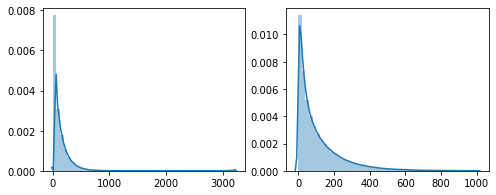

In [63]:
len_array = np.array(daily_lens)

for alpha in np.arange(0, 0.5, 0.05):
    upper, lower = np.round(1. - alpha, 2), np.round(alpha, 2)
    print(f'Lenght of sequence: {round(100 * upper)}%-{round(100 * lower)}% quantiles: {np.quantile(len_array, upper)}-{np.quantile(len_array, lower)}')

print(f'Length of sequence: mean: {len_array.mean()}, median: {np.quantile(len_array, 0.5)}.')

# plt.cla()
fig = plt.figure(figsize=(8, 3))

ax = fig.add_subplot(121)
sns.distplot(len_array, ax=ax)

ax = fig.add_subplot(122)
sns.distplot(len_array[len_array < 1000,], ax=ax)

plt.show()

### Token record stat

Lenght of sequence: 100.0%-0.0% quantiles: 34280.0-1.0
Lenght of sequence: 95.0%-5.0% quantiles: 1621.0-14.0
Lenght of sequence: 90.0%-10.0% quantiles: 1150.0-30.0
Lenght of sequence: 85.0%-15.0% quantiles: 894.0-47.0
Lenght of sequence: 80.0%-20.0% quantiles: 722.0-65.0
Lenght of sequence: 75.0%-25.0% quantiles: 595.0-86.0
Lenght of sequence: 70.0%-30.0% quantiles: 495.0-110.0
Lenght of sequence: 65.0%-35.0% quantiles: 414.0-136.0
Lenght of sequence: 60.0%-40.0% quantiles: 347.0-167.0
Lenght of sequence: 55.0%-45.0% quantiles: 290.0-202.0
Length of sequence: mean: 465.3097588628395, median: 243.0.


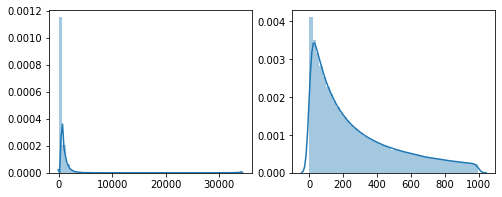

In [64]:
len_array = np.array(token_lens)

for alpha in np.arange(0, 0.5, 0.05):
    upper, lower = np.round(1. - alpha, 2), np.round(alpha, 2)
    print(f'Lenght of sequence: {round(100 * upper)}%-{round(100 * lower)}% quantiles: {np.quantile(len_array, upper)}-{np.quantile(len_array, lower)}')

print(f'Length of sequence: mean: {len_array.mean()}, median: {np.quantile(len_array, 0.5)}.')

# plt.cla()
fig = plt.figure(figsize=(8, 3))

ax = fig.add_subplot(121)
sns.distplot(len_array, ax=ax)

ax = fig.add_subplot(122)
sns.distplot(len_array[len_array < 1000,], ax=ax)

plt.show()